## Week 3 : Logistic Regression 
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Recap on Logistic Regression
2. Data for Classification Task
3. Classification task evaluation metrics
4. Dealing with data imbalance (self practice)
```

<hr>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. The Sigmoid fucnction

$$\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}$$
* **Domain**: \($-∞, +∞$\)
* **Range**: $(0, +1)$
* **Derivative**: $σ'(x) = \sigma(x)(1 - \sigma(x))$

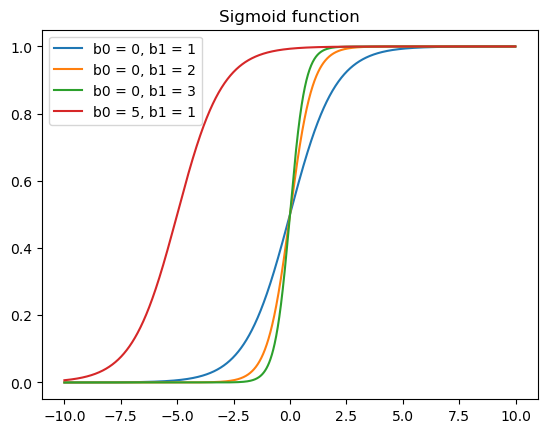

In [7]:
x = np.arange(-10, 10, 0.01)

def plot(b0, b1):
    p = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)

plot(0,1)
plot(0,2)
plot(0,3)
plot(5,1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

## 2. Data for Classification Task

* How is data for regression different from classification task different? 

Covid-19 Dataset collected is from March 2020 - November 2021. The target/goal is to predict the disease based on the patient state. 

<strong>Target Feature: Corona Result.</strong>

<strong>Task:</strong> apply the tools of machine learning to predict which patients got infected by Covid-19.

## 3. Load Data

In [11]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn: 
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_lab_sample'), con=conn, parse_dates=['test_date']) 
    
covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age
0,2021-02-12,0,0,0,0,0,Positive,No,male,Other,51
1,2020-10-14,0,0,0,0,0,Positive,No,male,Other,47
2,2021-02-22,0,0,0,0,0,Positive,No,female,Contact with confirmed,35
3,2021-03-06,1,0,0,0,1,Positive,No,female,Contact with confirmed,37
4,2021-09-24,0,0,0,0,0,Positive,No,female,Contact with confirmed,51


In [13]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            2000 non-null   datetime64[ns]
 1   cough                2000 non-null   int64         
 2   fever                2000 non-null   int64         
 3   sore_throat          2000 non-null   int64         
 4   shortness_of_breath  2000 non-null   int64         
 5   head_ache            2000 non-null   int64         
 6   corona_result        2000 non-null   object        
 7   age_60_and_above     2000 non-null   object        
 8   gender               2000 non-null   object        
 9   test_indication      1781 non-null   object        
 10  age                  2000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 172.0+ KB


## 3.1 Exploratory data analysis (EDA)

An approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods (i.e matplotlib, distribution plot ..)<br> 
Today we are going to try a tool called [ydata-profiling](https://github.com/ydataai/ydata-profiling). It can be easily be installed with:
1. pip: `pip3 install ydata-profiling`  
1. conda: `conda install -c conda-forge ydata-profiling
`

**Note:** All that is done by pandas profilling can be easily be achieved with pandas, matplotlib and numpy

In [16]:
import ydata_profiling

# Create the data profile report
profileReport = ydata_profiling.profile_report.ProfileReport(covid19_df)

In [17]:
profileReport.to_file('covid_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.2 Data preprocessing
1. How to deal with missing values? 
1. How to deal with categorical data? 
1. Is data scaling needed? 

<span style="color:red">TASK: Split data to train and test</span> <br>
<span style="color:red">TASK: Impute missing values</span> <br>
<span style="color:red">TASK: Encode categorical features</span> <br>
<span style="color:red">TASK: Use min-max scaler for feature scaling </span> <br>

In [20]:
!pip install category-encoders

In [21]:
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Select features 
covid19_df.drop(['test_date'], axis = 1, inplace=True)

# Encode the target label 
target_encoding = {'Negative':0, 'Positive':1}
covid19_df['corona_result'] = covid19_df['corona_result'].apply(lambda x : target_encoding.get(x))

X = covid19_df.drop(columns=['corona_result'])
y = covid19_df['corona_result']
# Split data to train and test
x_train, x_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

# imputing missing values
imputer = SimpleImputer(strategy ='most_frequent')
imputer = imputer.fit(x_train)
# transform the data
#imputed_data = imputer.transform(covid19_df)
#imputed_data = pd.DataFrame(imputed_data, columns=encoded_data.columns)
x_train = pd.DataFrame(imputer.transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns = x_test.columns)

In [23]:
# encode categorical features
def new_ohe(df, f_name, encoder):
    new_features = encoder.transform(df[f_name])
    new_columns = pd.DataFrame(new_features, columns= encoder.get_feature_names_out(f_name))
    new_df = pd.concat([df, new_columns], axis = 1 )
    new_df.drop(f_name, axis = 1, inplace = True)
    return new_df
    
features_to_encode = ['test_indication', 'age_60_and_above', 'gender']
encoder = OneHotEncoder()
encoder.fit(x_train[features_to_encode])

x_train = new_ohe(x_train, features_to_encode, encoder)
x_test = new_ohe(x_test, features_to_encode, encoder)

# TODO: feature scaling using MinMaxScaler


In [27]:
scaler = MinMaxScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=scaler.get_feature_names_out())
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=scaler.get_feature_names_out())

In [29]:
x_train.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age', 'test_indication_1', 'test_indication_2', 'test_indication_3',
       'test_indication_4', 'age_60_and_above_1', 'age_60_and_above_2',
       'gender_1', 'gender_2'],
      dtype='object')

## 4 Build, Train and Test Model

Now we are ready to see Logistic Regression in practice.

<span style="color:red">Task : Fit Logistic Regression  </span> <br>
<span style="color:red">Task : Output Accuracy, Precision, and Recall scores on test set </span>

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.7575
Testing precision = 0.8682170542635659
Testing recall = 0.5833333333333334


## 5. Prediction Results Interpretation & Model perfomence Measurement

1. looking at Logistic Regression Coefficients
2. Prediction threshold

### Task : 
1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

In [35]:
# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('cough', 0.9194269945628976)
('fever', 1.7573882958684865)
('sore_throat', 1.1770220224925476)
('shortness_of_breath', 0.8025281741357009)
('head_ache', 1.6644629020838284)
('age', -0.2988289493932881)
('test_indication_1', 1.4763689541945355)
('test_indication_2', -0.7865760783330271)
('test_indication_3', -0.2002777501328471)
('test_indication_4', -0.48974968989157774)
('age_60_and_above_1', -0.07771926033780378)
('age_60_and_above_2', 0.07748469617488328)
('gender_1', 0.04693338859453296)
('gender_2', -0.04716795275744404)


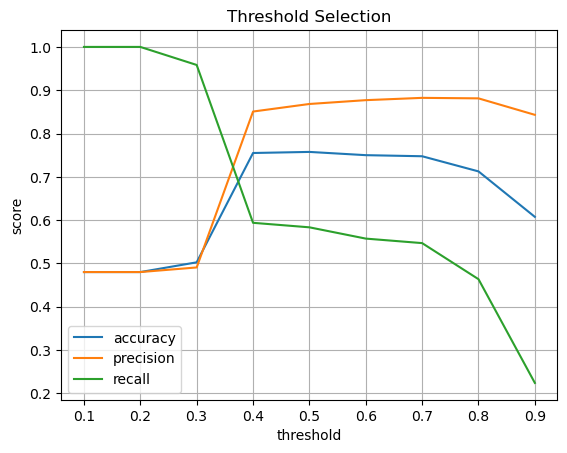

In [37]:
# TODO: calculate metrics for each threshold above and plot the result as below.
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pred_proba = clf.predict_proba(x_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

# Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? <br><br>

<table><tr><td>
<img align='center' src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' style='width: 350px;'>
</td><td>
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_002.png' style='width: 400px;'></td></tr></table>
<br>


<span style="color:red">Task: Implement a confussion matrix method from scratch using python list and numpy</span>

In [40]:
def calc_confusion_matrix(true_labels, pred_labels):
    """Compute confusion matrix to evaluate the accuracy of a classification
    
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    pred_labels : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    num_labels = np.unique(true_labels).size
    cm = np.zeros((num_labels, num_labels), dtype = int)
    for a, p in zip(true_labels, pred_labels):
        cm[a][p] += 1

    return cm

In [42]:
## computing confusion matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
print("Confusion Matrix for Test 1")
print(calc_confusion_matrix(y_true, y_pred))

covid_test_cm = calc_confusion_matrix(y_test, clf.predict(x_test))
print('Confusion Matrix for Covid-19:\n', covid_test_cm, '\n')

Confusion Matrix for Test 1
[[2 0 0]
 [0 0 1]
 [1 0 2]]
Confusion Matrix for Covid-19:
 [[191  17]
 [ 80 112]] 



## <center>Self-Practice  Task</center>

* Using `covid19_self_practice` table dataset given to you.
    1. Split the data to train and test set (80% training). 
    1. Fill missing values
    1. Encode categorical features
    1. Create new features from the existing features
    1. Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.
    1. Select the optimal prediction threshold
    1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them. 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn: 
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_lab_sample'), con=conn, parse_dates=['test_date']) 
    
covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age
0,2021-02-12,0,0,0,0,0,Positive,No,male,Other,51
1,2020-10-14,0,0,0,0,0,Positive,No,male,Other,47
2,2021-02-22,0,0,0,0,0,Positive,No,female,Contact with confirmed,35
3,2021-03-06,1,0,0,0,1,Positive,No,female,Contact with confirmed,37
4,2021-09-24,0,0,0,0,0,Positive,No,female,Contact with confirmed,51


In [7]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            2000 non-null   datetime64[ns]
 1   cough                2000 non-null   int64         
 2   fever                2000 non-null   int64         
 3   sore_throat          2000 non-null   int64         
 4   shortness_of_breath  2000 non-null   int64         
 5   head_ache            2000 non-null   int64         
 6   corona_result        2000 non-null   object        
 7   age_60_and_above     2000 non-null   object        
 8   gender               2000 non-null   object        
 9   test_indication      1781 non-null   object        
 10  age                  2000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 172.0+ KB


In [9]:
import ydata_profiling

# Create the data profile report
profileReport = ydata_profiling.profile_report.ProfileReport(covid19_df)

In [11]:
profileReport.to_file('covid_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Select features 
covid19_df.drop(['test_date'], axis = 1, inplace=True)

# Encode the target label 
target_encoding = {'Negative':0, 'Positive':1}
covid19_df['corona_result'] = covid19_df['corona_result'].apply(lambda x : target_encoding.get(x))

X = covid19_df.drop(columns=['corona_result'])
y = covid19_df['corona_result']
# Split data to train and test
x_train, x_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

# imputing missing values
imputer = SimpleImputer(strategy ='most_frequent')
imputer = imputer.fit(x_train)
# transform the data
#imputed_data = imputer.transform(covid19_df)
#imputed_data = pd.DataFrame(imputed_data, columns=encoded_data.columns)
x_train = pd.DataFrame(imputer.transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns = x_test.columns)

In [15]:
# encode categorical features
def new_ohe(df, f_name, encoder):
    new_features = encoder.transform(df[f_name])
    new_columns = pd.DataFrame(new_features, columns= encoder.get_feature_names_out(f_name))
    new_df = pd.concat([df, new_columns], axis = 1 )
    new_df.drop(f_name, axis = 1, inplace = True)
    return new_df
    
features_to_encode = ['test_indication', 'age_60_and_above', 'gender']
encoder = OneHotEncoder()
encoder.fit(x_train[features_to_encode])

x_train = new_ohe(x_train, features_to_encode, encoder)
x_test = new_ohe(x_test, features_to_encode, encoder)

# TODO: feature scaling using MinMaxScaler

In [17]:
scaler = MinMaxScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=scaler.get_feature_names_out())
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=scaler.get_feature_names_out())

In [20]:
print(x_train)

      cough  fever  sore_throat  shortness_of_breath  head_ache       age  \
0       0.0    0.0          0.0                  0.0        0.0  0.084507   
1       0.0    0.0          0.0                  0.0        1.0  0.366197   
2       0.0    0.0          0.0                  0.0        0.0  0.154930   
3       0.0    0.0          0.0                  0.0        0.0  0.084507   
4       0.0    0.0          0.0                  0.0        0.0  0.098592   
...     ...    ...          ...                  ...        ...       ...   
1595    0.0    0.0          0.0                  0.0        0.0  0.295775   
1596    0.0    0.0          0.0                  0.0        0.0  0.183099   
1597    0.0    0.0          0.0                  0.0        0.0  0.042254   
1598    0.0    0.0          0.0                  0.0        0.0  0.042254   
1599    0.0    0.0          0.0                  0.0        0.0  0.746479   

      test_indication_1  test_indication_2  test_indication_3  \
0         

In [26]:
print(X)

      cough  fever  sore_throat  shortness_of_breath  head_ache  \
0         0      0            0                    0          0   
1         0      0            0                    0          0   
2         0      0            0                    0          0   
3         1      0            0                    0          1   
4         0      0            0                    0          0   
...     ...    ...          ...                  ...        ...   
1995      0      0            0                    0          0   
1996      1      1            0                    0          0   
1997      0      0            0                    0          0   
1998      0      1            0                    0          1   
1999      0      1            0                    0          0   

     age_60_and_above  gender         test_indication  age  
0                  No    male                   Other   51  
1                  No    male                   Other   47  
2           

In [32]:
# Creating new features
x_train['multiplication_feature'] = x_train['cough'] + x_train['head_ache']
x_test['multiplication_feature'] = x_test['cough'] + x_test['head_ache']
print(x_train)

      cough  fever  sore_throat  shortness_of_breath  head_ache       age  \
0       0.0    0.0          0.0                  0.0        0.0  0.084507   
1       0.0    0.0          0.0                  0.0        1.0  0.366197   
2       0.0    0.0          0.0                  0.0        0.0  0.154930   
3       0.0    0.0          0.0                  0.0        0.0  0.084507   
4       0.0    0.0          0.0                  0.0        0.0  0.098592   
...     ...    ...          ...                  ...        ...       ...   
1595    0.0    0.0          0.0                  0.0        0.0  0.295775   
1596    0.0    0.0          0.0                  0.0        0.0  0.183099   
1597    0.0    0.0          0.0                  0.0        0.0  0.042254   
1598    0.0    0.0          0.0                  0.0        0.0  0.042254   
1599    0.0    0.0          0.0                  0.0        0.0  0.746479   

      test_indication_1  test_indication_2  test_indication_3  \
0         

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.765
Testing precision = 0.9057971014492754
Testing recall = 0.6067961165048543


In [38]:
# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('cough', 0.13594741399368712)
('fever', 1.60720232263655)
('sore_throat', 0.6830905006006055)
('shortness_of_breath', 0.9265224564436116)
('head_ache', 0.7039081901811027)
('age', -0.0525608783047263)
('test_indication_1', -0.6899821986846741)
('test_indication_2', 1.6180635512991448)
('test_indication_3', -0.47384329433107014)
('test_indication_4', -0.45446708825017196)
('age_60_and_above_1', 0.04881998191190132)
('age_60_and_above_2', -0.049049011878673256)
('gender_1', -0.04309680899673345)
('gender_2', 0.04286777902995458)
('multiplication_feature', 0.8398556041747922)


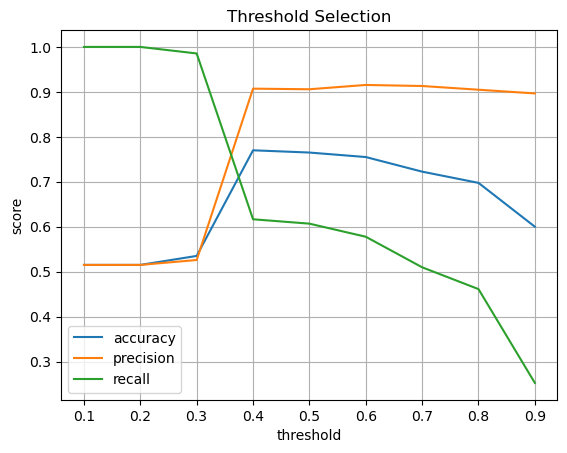

In [40]:
# TODO: calculate metrics for each threshold above and plot the result as below.
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pred_proba = clf.predict_proba(x_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

In [44]:
def  calc_confusion_matrix(true_labels, pred_labels):
    """Compute confusion matrix to evaluate the accuracy of a classification
    
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    pred_labels : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    num_labels = np.unique(true_labels).size
    cm = np.zeros((num_labels, num_labels), dtype = int)
    for a, p in zip(true_labels, pred_labels):
        cm[a][p] += 1

    return cm

In [46]:
## computing confusion matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
print("Confusion Matrix for Test 1")
print(calc_confusion_matrix(y_true, y_pred))

covid_test_cm = calc_confusion_matrix(y_test, clf.predict(x_test))
print('Confusion Matrix for Covid-19:\n', covid_test_cm, '\n')

Confusion Matrix for Test 1
[[2 0 0]
 [0 0 1]
 [1 0 2]]
Confusion Matrix for Covid-19:
 [[181  13]
 [ 81 125]] 

